### 100hr and 1000hr Fuel Moisture Calcuations from US NFDRS Version 3
#### Compiled by: W. Matt Jolly, USFS, RMRS, Missoula Fire Sciences Laboratory
#### 03 Dec 2024


In [1]:
from math import *
## \fn CalcDaylightHours(self,Julian)
## \brief Calculate Daylight hours as a function of Latitude and Julian Date
## \param Julian Julian Year Day (1-366)
## Requires that Latitude already be set as part of the class intialization
def CalcDaylightHours(Lat,Julian):
    phi = 0.0
    xfact = 0.0
    decl = 0.0
    tla = 0.0
    phi = tan(Lat * 0.01745) * -1.0
    xfact = (Julian - 80) * 0.01745
    decl = 23.5 * sin(xfact)
    decl = decl * 0.01745
    tla = phi * sin(decl)
    if (fabs(tla) < .01):
        tla = 0.01
    else:
        if (tla >= 1.0):
            tla = 0.99999999
        else:
            if (tla <= -1.0):
                tla = -.9999999
    tla = atan(sqrt((1.0 - tla * tla))/tla)
    if (tla < 0.0):
        tla = tla + 3.141593
    return tla * 7.64

## \fn eqmc (self,Temp,RH)
## \brief Calculate the equilibrium moisture content
## \param Temp Temperature (deg F)
def eqmc (Temp,RH):

    if(RH > 50):
        return  (21.0606 + 0.005565 * RH**2 - 0.00035 * RH * Temp - 0.483199 * RH)
    if(RH > 10) and (RH < 51):
        return (2.22749 + 0.160107 * RH - 0.014784 * Temp)
    else:
        return (0.03229 + 0.281073 * RH - 0.000578 * RH * Temp)


In [2]:
## \fn hundredthous (Lat,MaxTemp,MaxRH,MinTemp, MinRH,Julian,PrecipDur,Hist1000,HistBndryT)
## \brief Calculate the hundred and thousand hour moisture contents
## \param Lat Latitude (degrees)
## \param Temp Temperature (deg F)
## \param RH Relative Humidity (%) 
## \param MaxTemp 24-hour Maximum Temperature (deg F)
## \param MaxRH 24-hour Maximum Relative Humidity (%)
## \param MinTemp 24-hour Minimum Temperature (deg F)
## \param MinRH 24-hour Minimum Relative Humidity (%)
## \param Julian Julian Year Day (1-366)
## \param 24-hour Precipitation Duration (hours)
## \param Hist1000 and HistBndryT Historical conditions for FM1000 for last 7 days
## \param Y100 and Y100 Yesterday's FM100 and FM1000
def hundredthous (Lat,MaxTemp,MaxRH,MinTemp, MinRH,Julian,PrecipDur,Hist1000,HistBndryT,Y100,Y1000):
    bndryBar = float(0.0 )
    Daylight = CalcDaylightHours(Lat, Julian)
    emcMin = eqmc (MaxTemp, MinRH)
    emcMax = eqmc (MinTemp, MaxRH)
    emcBar = (Daylight * emcMin + (24 - Daylight) * emcMax) / 24
    bndryH = ((24.0 - PrecipDur) * emcBar + PrecipDur * (.5 * PrecipDur + 41)) / 24

    # Calculate the 100 hour fuel moistures
    MC100 = Y100 + .3156 * (bndryH - Y100)

    # Calculate the 1000 hour fuel moistures
    bndryT = ((24.0 - PrecipDur) * emcBar + PrecipDur * (2.7 * PrecipDur + 76)) / 24

    # Track the Boundary Condition Arrays for FM1000
    for i in range (0,6):
        HistBndryT[i] = HistBndryT[i+1]
        bndryBar = bndryBar + HistBndryT[i]
    HistBndryT[6] = bndryT
    bndryBar = (bndryBar + bndryT) / 7
    MC1000 = Hist1000[0] + (bndryBar - Hist1000[0]) * .3068
    for i in range (0,6):
        Hist1000[i] = Hist1000[i+1] 
    Hist1000[6] = MC1000
    Y100 = MC100
    Y1000 = MC1000
    return MC100, MC1000, Hist1000,HistBndryT

#### Let's test the function on 3 years of data from Missoula, MT (RAWS ID 241513)

In [3]:
import pandas as pd
df = pd.read_csv("MSO.csv")
df.rename(columns=lambda x: x.strip(), inplace=True)
df['DateTime']=pd.to_datetime(df['DATE'].astype(str) + " 13", format='%m/%d/%Y %H')

In [4]:
df.columns

Index(['DATE', 'MaxT', 'MinT', 'MxRH', 'MnRH', 'RnDr', 'Unnamed: 6',
       'DateTime'],
      dtype='object')

In [5]:
Hist1000 = [30,30,30,30,30,30,30]
HistBndryT =[30,30,30,30,30,30,30]
Y100 = 30
Y1000 = 30

#### Iterate over the rows in the dataframe

In [6]:
Lat = 46.82
MC100vals = []
MC1000vals = []

for i,row in df.iterrows():
    MaxTemp = row['MaxT']
    MaxRH = row['MxRH']
    MinTemp = row['MinT']
    MinRH = row['MnRH']
    PrecipDur = row['RnDr']
    Julian = row['DateTime'].dayofyear
    # Calculate the FM100 and FM1000 and retrieve the hist arrays 
    MC100, MC1000, Hist1000,HistBndryT = hundredthous(Lat,MaxTemp,MaxRH,MinTemp, MinRH,Julian,PrecipDur,Hist1000,HistBndryT,Y100,Y1000)
    MC100vals.append(MC100)
    MC1000vals.append(MC1000)
    Y100 = MC100
    Y1000 = MC1000

### Plot the FM100 and FM1000

In [7]:
df['MC100'] = MC100vals
df['MC1000'] = MC1000vals

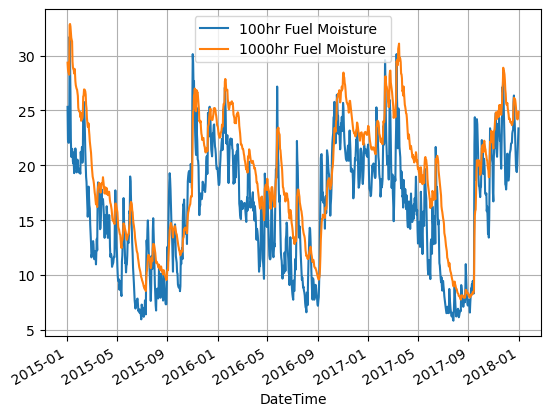

In [9]:
ax=df.plot(x='DateTime',y='MC100',label='100hr Fuel Moisture')
df.plot(x='DateTime',y='MC1000',label='1000hr Fuel Moisture',ax=ax)
ax.grid(True)